# Robust Training with Jacobinet and Adversarial Attacks

This tutorial demonstrates the use of Jacobinet for robust training in neural networks. 
Jacobinet allows the backward pass of a neural network to be represented as a neural network with shared weights. 

**Goals:**
- Understand adversarial attacks (FGSM, PGD) and their impact on model robustness.
- Use Jacobinet to implement robust training by regularizing against adversarial examples.
- Evaluate robustness with AutoAttack for both baseline and robust training.

We will:
1. Train a baseline model and evaluate its adversarial robustness.
2. Train a robust model with adversarial regularization using Jacobinet.
3. Compare adversarial success rates for both models.


## Load and Preprocess Data

We will use the MNIST dataset for this tutorial. The dataset is normalized to the [0, 1] range and reshaped for compatibility with the convolutional model.


In [36]:
input_shape = (1, 2, 2, 3)
import torch

x = torch.tensor( np.asarray(np.arange(np.prod(input_shape)).reshape(input_shape), dtype='float32'))
y = keras.layers.UpSampling2D(size=(2,2))(x)
print(y.shape)
print(keras.ops.reshape(y, [-1, 2,5,  3])[0,:, 0])

torch.Size([1, 2, 4, 6])


RuntimeError: shape '[-1, 2, 5, 3]' is invalid for input of size 48

In [28]:
d = keras.layers.Dropout(0.5)

output = d.call(x, training=True)

In [42]:
import keras.ops as K
axis=(2, 3)
indices_0 = K.argmax(x, axis[0])
mask_0 = K.one_hot(indices_0, 2, axis=axis[0])
indices_1 = K.argmax(x, axis[1])
mask_1 = K.one_hot(indices_1, 3, axis=axis[1])

print(mask_0.shape)

print(mask_1.shape)

torch.Size([1, 2, 2, 3])
torch.Size([1, 2, 2, 3])


In [51]:
x[0,1]

tensor([[ 6.,  7.,  8.],
        [ 9., 10., 11.]])

In [50]:
(mask_0*mask_1)[0,0]

tensor([[0., 0., 0.],
        [0., 0., 1.]], device='mps:0')

In [49]:
mask_1[0,0]

tensor([[0., 0., 1.],
        [0., 0., 1.]], device='mps:0')

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST data and split it into training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Reshape images to have an additional channel dimension (1, 28, 28)
x_train = np.expand_dims(x_train, 1)
x_test = np.expand_dims(x_test, 1)

# Convert class labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


## Define and Train the Baseline Model

We will build a simple Convolutional Neural Network (CNN) using Keras to serve as the baseline model. 
This model will be trained on MNIST and evaluated for accuracy on clean data.


In [2]:
from keras import layers, Sequential

# Define the model architecture
model = Sequential(
    [
        layers.Input(shape=(1, 28, 28)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(10)
    ]
)
model.summary()

train_model = Sequential(model.layers + [layers.Activation('softmax')])
train_model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=["accuracy"])

train_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 26, 26)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 13, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 11, 11)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        77,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,266 (376.04 KB)

 Trainable params: 96,266 (376.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
  5/422 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.2174 - loss: 2.2951

/Users/ducoffe_m/Library/Python/3.9/lib/python/site-packages/keras/src/backend/torch/optimizers/torch_adam.py:35: UserWarning: The operator 'aten::_foreach_mul_.Scalar' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_mul_(m_list, self.beta_1)


422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.7453 - loss: 1.7422 - val_accuracy: 0.9715 - val_loss: 1.4931
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9656 - loss: 1.4982 - val_accuracy: 0.9803 - val_loss: 1.4826


## Evaluate Robustness of Baseline Model

We use AutoAttack, a strong adversarial attack framework, to test the baseline model's robustness. 
AutoAttack generates adversarial examples by varying the attack radius (`epsilon`), and we measure the model's accuracy on these examples.


0.01
0.03
0.05
0.07
0.09
0.12
0.14
0.16
0.18
0.2


Text(0, 0.5, 'Adversarial success rate')

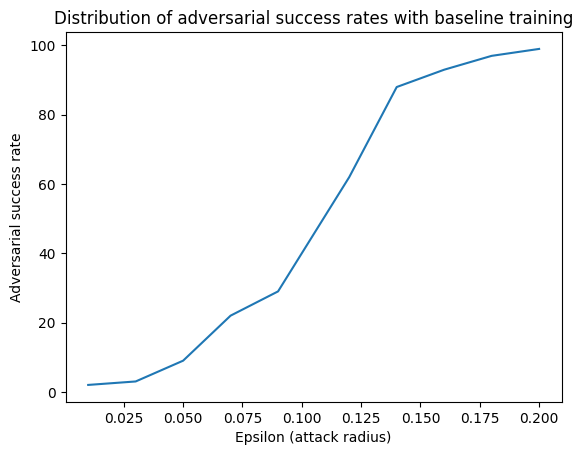

In [4]:
import torchattacks
import torch

# Test robustness at different epsilon values
n = 100
random_index = np.random.permutation(len(x_test))[:n]
adv_acc = []
eps_values = [np.round(eps_i, 2) for eps_i in np.linspace(0.01, 0.2, 10)]

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
    adv_acc.append(acc)

plt.plot(eps_values, adv_acc)
plt.title('Distribution of adversarial success rates with baseline training')
plt.xlabel('Epsilon (attack radius)')
plt.ylabel('Adversarial success rate')


## Robust Training with Jacobinet

To improve robustness, we will train a model that outputs predictions for both clean and adversarial examples. 
Jacobinet is used to create adversarial examples with Projected Gradient Descent (PGD), which are integrated into the training process.


In [3]:
from jacobinet.attacks import get_adv_model

pgd_model = get_adv_model(model, loss='logits', epsilon=1e-2, attack='pgd', n_iter=20) # think of clipping

x = layers.Input(shape=(1, 28, 28))
y = layers.Input((10,))

model_adv = keras.models.Model([x, y], [model(x), model(pgd_model([x, y]))])
model_adv.compile('adam',
                  loss=[keras.losses.CategoricalCrossentropy(from_logits=True),
                        keras.losses.CategoricalCrossentropy(from_logits=True)],
                  metrics=['accuracy', 'accuracy'], loss_weights=[1, 1])

model_adv.fit([x_train, y_train], [y_train, y_train], batch_size=128, epochs=4, validation_split=0.1)


Epoch 1/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 338s 802ms/step - loss: 2.5806 - sequential_accuracy: 0.9699 - sequential_accuracy_1: 0.5667 - sequential_loss: 2.4658 - val_loss: 0.5591 - val_sequential_accuracy: 0.9840 - val_sequential_accuracy_1: 0.8567 - val_sequential_loss: 0.4915
Epoch 2/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 337s 799ms/step - loss: 0.6168 - sequential_accuracy: 0.9758 - sequential_accuracy_1: 0.8433 - sequential_loss: 0.5330 - val_loss: 0.4349 - val_sequential_accuracy: 0.9865 - val_sequential_accuracy_1: 0.8898 - val_sequential_loss: 0.3781
Epoch 3/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 337s 800ms/step - loss: 0.4864 - sequential_accuracy: 0.9789 - sequential_accuracy_1: 0.8786 - sequential_loss: 0.4189 - val_loss: 0.3643 - val_sequential_accuracy: 0.9877 - val_sequential_accuracy_1: 0.9108 - val_sequential_loss: 0.3123
Epoch 4/4
422/422 ━━━━━━━━━━━━━━━━━━━━ 342s 811ms/step - loss: 0.3987 - sequential_accuracy: 0.9831 - sequential_accuracy_1: 0.8972 - sequential_loss: 0.3432 - val_loss:

In [6]:
import torchattacks
import torch
auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.2)
acc_batch = []
for i in range(10):
    batch = i + np.arange(100)
    adv_data_robust = auto_attack(torch.Tensor(x_test[batch]), torch.tensor(y_test[batch].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[batch].argmax(-1))[0]) / len(batch) * 100
    print(acc)
    acc_batch.append(acc)


13.0


KeyboardInterrupt: 

In [42]:
model.save_weights('pgd_training_mnist_0.1_97.84_robust_acc.weights.h5')

In [12]:
n = 100
random_index = np.random.permutation(len(x_test))[:n]

In [14]:
auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.2)
adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
print(acc) # 0.2

18.0


In [15]:
auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=0.3)
adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
print(acc) # 0.3

100.0


## Evaluate Robustness of Robust Model

We use AutoAttack again to evaluate the robust model under varying attack radii. 
This allows us to compare the adversarial success rates of the baseline and robust models.


In [ ]:
adv_acc_robust = []

for eps in eps_values:
    print(eps)
    auto_attack = torchattacks.attacks.autoattack.AutoAttack(model, eps=eps)
    adv_data_robust = auto_attack(torch.Tensor(x_test[random_index]), torch.tensor(y_test[random_index].argmax(-1)))
    acc = len(np.where(model.predict(adv_data_robust, verbose=0).argmax(-1) != y_test[random_index].argmax(-1))[0]) / len(random_index) * 100
    adv_acc_robust.append(acc)

plt.plot(eps_values, adv_acc, label='Baseline Training')
plt.plot(eps_values, adv_acc_robust, label='Robust Training')
plt.title('Adversarial Success Rates: Baseline vs. Robust Training')
plt.xlabel('Epsilon (attack radius)')
plt.ylabel('Adversarial success rate')
plt.legend()


## Conclusion

In this tutorial, we explored the use of Jacobinet for robust training against adversarial attacks. Key takeaways include:
1. Baseline models are vulnerable to adversarial examples, as shown by the high adversarial success rates.
2. Robust training with Jacobinet significantly improves resistance to adversarial attacks.
3. This workflow can be extended to other datasets and adversarial attack frameworks.

Jacobinet's ability to treat the backward pass as a neural network opens exciting possibilities for research in robustness and adversarial machine learning.
